<a href="https://colab.research.google.com/github/sarveshmalagi/ml_hackathons/blob/master/amex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving amx_data.zip to amx_data.zip


In [0]:
!unzip amx_data.zip

In [5]:
!ls

amx_data  amx_data.zip	__MACOSX  sample_data


In [0]:
import pandas as pd
import numpy as np

In [0]:
train_df = pd.read_csv('amx_data/train.csv')
campaign_df = pd.read_csv('amx_data/campaign_data.csv')
item_data_df = pd.read_csv('amx_data/item_data.csv')
customer_transaction_df = pd.read_csv('amx_data/customer_transaction_data.csv')
coupon_item_mapping_df = pd.read_csv('amx_data/coupon_item_mapping.csv')
customer_demographics_df = pd.read_csv('amx_data/customer_demographics.csv')

In [0]:
train_df.info()

#Checking the distribution of labels

In [0]:
train_df.groupby('redemption_status')['id'].nunique()

redemption_status
0    77640
1      729
Name: id, dtype: int64

In [0]:
train_df.redemption_status.hist()

#Feature Engineering

In [0]:
def feature_engineering(df, campaign_df, item_data_df, customer_transaction_df, coupon_item_mapping_df, customer_demographics_df):
  
  campaign_df.start_date = pd.to_datetime(campaign_df.start_date)
  campaign_df['start_year'] = campaign_df.start_date.dt.year
  campaign_df['start_month'] = campaign_df.start_date.dt.month
  campaign_df['start_day'] = campaign_df.start_date.dt.dayofweek
  campaign_df['start_quarter'] = campaign_df.start_date.dt.quarter
  
  campaign_df.end_date = pd.to_datetime(campaign_df.end_date)
  campaign_df['end_year'] = campaign_df.end_date.dt.year
  campaign_df['end_month'] = campaign_df.end_date.dt.month
  campaign_df['end_day'] = campaign_df.end_date.dt.dayofweek
  campaign_df['end_quarter'] = campaign_df.end_date.dt.quarter
  
  df = df.merge(campaign_df, how='left', on='campaign_id')
  
  customer_demographics_df['no_of_children'] = customer_demographics_df['no_of_children'].replace('3+', 3).astype(float)
  customer_demographics_df['family_size'] = customer_demographics_df['family_size'].replace('5+', 5).astype(float)
  customer_demographics_df['age_range'].fillna('46-55', inplace=True)
  age_map = {
      '18-25': 1,
      '26-35': 2,
      '36-45': 3,
      '46-55': 4,
      '56-70': 5,
      '70+': 6
  }
  customer_demographics_df['age_range'] = customer_demographics_df['age_range'].map(age_map)
  df = df.merge(customer_demographics_df, how='left', on='customer_id')
  
  customer_transaction_df['date'] = pd.to_datetime(customer_transaction_df['date'])
  
  mean_quantities = customer_transaction_df.groupby('customer_id')['quantity'].mean().to_dict()
  df['quantity_mean'] = df['customer_id'].map(mean_quantities)
  
  mean_selling_prices = customer_transaction_df.groupby('customer_id')['selling_price'].mean().to_dict()
  df['selling_price_mean'] = df['customer_id'].map(mean_selling_prices)
  
  mean_other_discount = customer_transaction_df.groupby('customer_id')['other_discount'].mean().to_dict()
  df['other_discount_mean'] = df['customer_id'].map(mean_other_discount)
  
  mean_coupon_discount = customer_transaction_df.groupby('customer_id')['coupon_discount'].mean().to_dict()
  df['coupon_discount_mean'] = df['customer_id'].map(mean_coupon_discount)
  
  count_non_zero_coupon_discount = customer_transaction_df.groupby('customer_id')['coupon_discount'].apply(list).apply(np.count_nonzero).to_dict()
  df['non_zero_coupon_discount'] = df['customer_id'].map(count_non_zero_coupon_discount)
  
  count_transactions = customer_transaction_df.groupby('customer_id')['coupon_discount'].count().to_dict()
  df['count_transactions'] = df['customer_id'].map(count_transactions)
  
  df['coupon_usage_ratio'] = df['non_zero_coupon_discount']/df['count_transactions']
  
  item_counts = coupon_item_mapping_df.groupby('coupon_id')['item_id'].count().to_dict()
  df['item_count'] = df['coupon_id'].map(item_counts)
  
  coupon_item_mapping_df = coupon_item_mapping_df.merge(item_data_df, how = 'left', on = 'item_id')  
  
  count_coupon_usage = coupon_item_mapping_df.groupby('coupon_id')['coupon_discount'].apply(list).apply(np.count_nonzero).to_dict()
  df['coupon_usage_count'] = df['customer_id'].map(count_coupon_usage)
  
  item_count = coupon_item_mapping_df.groupby('coupon_id')['item_id'].count().to_dict()
  df['item_count_by_coupon'] = df['coupon_id'].map(item_count)
  
  brand_unique = coupon_item_mapping_df.groupby('coupon_id')['brand'].nunique().to_dict()
  df['brand_unique_by_coupon'] = df['coupon_id'].map(brand_unique)
  
  
  df['marital_status'].fillna('NA', inplace=True)
  df['family_size'].fillna(customer_demographics_df['family_size'].mean(), inplace=True)
  df['no_of_children'].fillna(customer_demographics_df['no_of_children'].mean(), inplace=True)
  df['rented'].fillna(customer_demographics_df['rented'].mean(), inplace=True)
  df['income_bracket'].fillna(customer_demographics_df['income_bracket'].mean(), inplace=True)
  
  categorical_columns = ['marital_status', 'campaign_type']
  for col in categorical_columns:
    df = pd.concat([df, pd.get_dummies(df[col]).rename(columns=lambda x: col + '_' + str(x))], axis=1, sort=False)
    del df[col]
    
  columns_to_delete = ['id', 'campaign_id', 'coupon_id', 'customer_id', 'start_date', 'end_date']
  for col in columns_to_delete:
    del df[col]
    
  return df

In [0]:
fe_train_df = feature_engineering(train_df, campaign_df, item_data_df, customer_transaction_df, coupon_item_mapping_df, customer_demographics_df)

In [21]:
fe_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 28 columns):
redemption_status           78369 non-null int64
start_year                  78369 non-null int64
start_month                 78369 non-null int64
start_day                   78369 non-null int64
start_quarter               78369 non-null int64
end_year                    78369 non-null int64
end_month                   78369 non-null int64
end_day                     78369 non-null int64
end_quarter                 78369 non-null int64
age_range                   43661 non-null float64
rented                      78369 non-null float64
family_size                 78369 non-null float64
no_of_children              78369 non-null float64
income_bracket              78369 non-null float64
quantity_mean               78369 non-null float64
selling_price_mean          78369 non-null float64
other_discount_mean         78369 non-null float64
coupon_discount_mean        78369 non-null

In [251]:
select_customer_id = customer_transaction_df['customer_id'] == 1
non_zero_coupon_discount = customer_transaction_df['coupon_discount'] != 0

customer_filtered = customer_transaction_df[select_customer_id]
customer_filtered[non_zero_coupon_discount].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


(78, 7)

In [0]:
import seaborn as sns

In [0]:
continuous_features = ['age_range', 'family_size', 'no_of_children', 'selling_price_mean', 'other_discount_mean', 'coupon_discount_mean', 
                      'item_count_by_coupon', 'brand_unique_by_coupon', 'redemption_status']

sns.distplot(fe_train_df['brand_unique_by_coupon'])

In [22]:
fe_train_df.head()

,redemption_status,start_year,start_month,start_day,start_quarter,end_year,end_month,end_day,end_quarter,age_range,rented,family_size,no_of_children,income_bracket,quantity_mean,selling_price_mean,other_discount_mean,coupon_discount_mean,non_zero_coupon_discount,count_transactions,coupon_usage_ratio,item_count_by_coupon,brand_unique_by_coupon,marital_status_Married,marital_status_NA,marital_status_Single,campaign_type_X,campaign_type_Y
0,0,2013,5,6,2,2013,5,1,2,4.0,0.000000,1.000000,1.788288,5.000000,340.487097,184.260484,-33.168935,-0.287258,1,310,0.003226,125,2,0,1,0,1,0
1,0,2013,5,6,2,2013,5,1,2,3.0,0.000000,2.000000,1.788288,3.000000,31.540260,234.247013,-27.699169,-3.215039,12,385,0.031169,3,1,1,0,0,1,0
2,0,2013,11,6,4,2013,12,2,4,4.0,0.000000,2.000000,1.788288,7.000000,1.392784,121.094495,-17.795660,-2.212082,85,970,0.087629,67,1,1,0,0,0,1
3,0,2013,5,6,2,2013,5,1,2,NaN,0.053947,2.161842,1.788288,4.715789,1.291139,98.276034,-16.655570,-0.751477,2,237,0.008439,4,1,0,1,0,1,0
4,0,2013,2,5,1,2013,5,5,2,4.0,0.000000,2.000000,1.788288,3.000000,247.443060,120.636103,-20.524733,-0.471548,10,562,0.017794,32,1,1,0,0,1,0


In [0]:
fe_train_df['age_range'].hist()

In [0]:
Y = fe_train_df['redemption_status']
del fe_train_df['redemption_status']

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(fe_train_df, Y, test_size=0.2, random_state=101)

In [0]:
Y_test.hist()

In [26]:
kwargs = {'eval_metric': 'auc'}
model = XGBClassifier(n_estimators=500, max_depth=3, scale_pos_weight=200, gamma = 0.2, verbosity=3, **kwargs)
model.fit(X_train, Y_train)

[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11:09:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nod

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=200, seed=None,
              silent=None, subsample=1, verbosity=3)

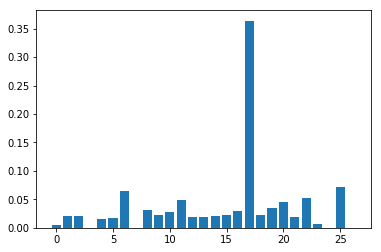

In [27]:
import matplotlib.pyplot as plt

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [0]:
col_names = X_train.columns
feat_imp = dict(zip(col_names, model.feature_importances_))

In [0]:
import operator
sorted_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)

In [30]:
sorted_imp[:20]

[('non_zero_coupon_discount', 0.36394688),
 ('campaign_type_X', 0.07096),
 ('end_day', 0.06468672),
 ('marital_status_Married', 0.052553564),
 ('no_of_children', 0.04873089),
 ('item_count_by_coupon', 0.045134928),
 ('coupon_usage_ratio', 0.03504349),
 ('age_range', 0.030836018),
 ('coupon_discount_mean', 0.028884383),
 ('family_size', 0.028104335),
 ('count_transactions', 0.023298535),
 ('other_discount_mean', 0.022719169),
 ('rented', 0.021789538),
 ('start_month', 0.02127037),
 ('start_day', 0.020362092),
 ('selling_price_mean', 0.019914906),
 ('income_bracket', 0.019643683),
 ('brand_unique_by_coupon', 0.019281754),
 ('quantity_mean', 0.01813398),
 ('end_month', 0.016564555)]

In [0]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
  class_report = classification_report(y_true, y_pred, target_names = ['0', '1'])
  print(class_report)

In [0]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_pred):
  print(confusion_matrix(y_true, y_pred))

In [33]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.97%


In [44]:
Y_test.sum()

146

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(Y_test, predictions, pos_label=1)
auc(fpr, tpr)

0.8035726888413685

In [35]:
class_report = classification_report(Y_test, predictions, target_names = ['0', '1'])
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     15528
           1       0.05      0.73      0.10       146

    accuracy                           0.88     15674
   macro avg       0.53      0.80      0.52     15674
weighted avg       0.99      0.88      0.93     15674



In [36]:
print(confusion_matrix(Y_test, predictions))

[[13682  1846]
 [   40   106]]


In [0]:
test_df = pd.read_csv('amx_data/test_QyjYwdj.csv')

In [0]:
fe_test_df = feature_engineering(test_df, campaign_df, item_data_df, customer_transaction_df, coupon_item_mapping_df, customer_demographics_df)

In [0]:
fe_test_df.head()

In [0]:
predictions = model.predict(fe_test_df)

In [0]:
submission = pd.DataFrame({
                'id': test_df['id'],
                'redemption_status': predictions
             })

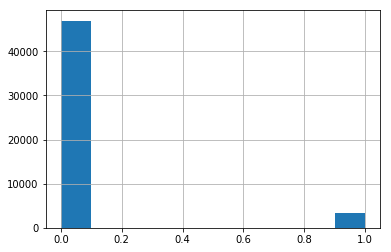

In [166]:
submission['redemption_status'].hist()

In [0]:
submission.to_csv('amex_submission.csv', index=False)
from google.colab import files
files.download('amex_submission.csv')